In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model

In [2]:
# Load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)
# seed = np.random.seed(156703)
# x_train, x_test = tf.keras.utils.split_dataset(input, right_size=test_split, shuffle = True, seed=seed)
# y_train, y_test = tf.keras.utils.split_dataset(noise_output, right_size=test_split, shuffle = True, seed=seed)

### Enter your tag as unique id for saving

In [3]:
tag = str("sQNN2-17032023-SGD")

Params in the quantum layer to train: 15
0: ──H──RX(0.12)──Rot(0.12,0.06,0.07)─╭●──────────╭X─┤  <Z>
1: ──H──RX(0.07)──Rot(0.23,0.09,0.09)─╰X─╭●───────│──┤  <Z>
2: ──H──RX(1.00)──Rot(0.70,0.78,0.69)────╰X─╭●────│──┤  <Z>
3: ──H──RX(1.00)──Rot(0.12,0.36,0.20)───────╰X─╭●─│──┤  <Z>
4: ──H──RX(0.05)──Rot(0.60,0.25,0.17)──────────╰X─╰●─┤  <Z>


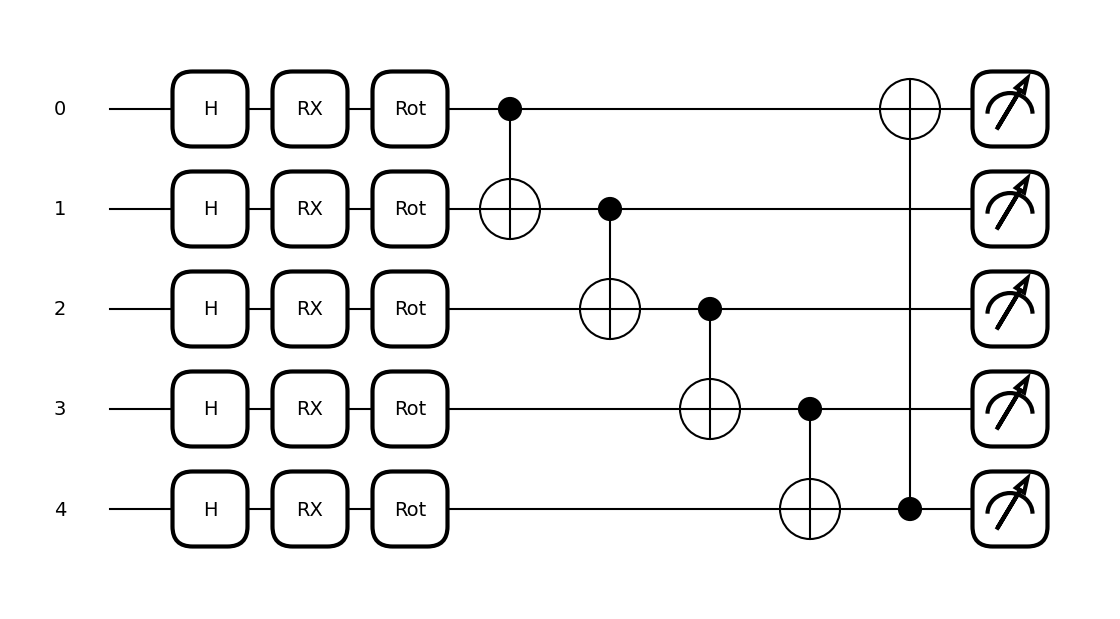

<Figure size 640x480 with 0 Axes>

In [4]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
params = 3
weight_shapes = {"weights": (n_qubits,params)}
n_qcParams = params*n_qubits
print(f"Params in the quantum layer to train: {n_qcParams}")

dev = qml.device("default.qubit", wires=n_qubits)  # number of shots default? =1 du Horst

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
    qml.broadcast(qml.RX, wires=range(n_qubits), parameters=inputs, pattern="single")
    qml.broadcast(qml.Rot, wires=range(n_qubits), parameters=weights, pattern="single")
    qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="ring")
    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(qnode)(x_train[0,:],np.random.rand(n_qubits,3)))
fig, ax = qml.draw_mpl(qnode)(x_train[0,:],np.random.rand(n_qubits,3, requires_grad=True))
plt.show()
plt.savefig("archive/Qnode-"+tag+".png")

In [5]:
#Create a simple ANN
import numpy as np
clear_session()
tf.keras.backend.set_floatx('float64')
layer_0 = Input(shape=(x_train.shape[1],))
layer_1 = Dense(5, activation="relu")
layer_2 = Dense(5, activation="linear")
ann = Sequential([layer_0, layer_1, qlayer, layer_2])
print(f"Params in the quantum layer to train: {n_qcParams}")
ann.summary()
plot_model(ann)

Params in the quantum layer to train: 15
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 0 (unused)
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
#Training
def scheduler(epoch, lr):
    if epoch < 6:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=5, patience=3)

optSGD = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.5)
optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.2, momentum=0.5)

ann.compile(optSGD, loss='mean_squared_error', metrics=['mean_absolute_error'])

ann_history = ann.fit(x_train, y_train, epochs=20, batch_size=25, validation_split=0.25, callbacks=[LearningRateScheduler, EarlyStopping])

Epoch 1/20
31/31 [==============================] - 89s 3s/step - loss: 2052.2511 - mean_absolute_error: 28.2793 - val_loss: 43.7618 - val_mean_absolute_error: 5.4533 - lr: 0.2000
Epoch 2/20
31/31 [==============================] - 87s 3s/step - loss: 48.7916 - mean_absolute_error: 5.7332 - val_loss: 44.1790 - val_mean_absolute_error: 5.5150 - lr: 0.2000
Epoch 3/20
31/31 [==============================] - 77s 3s/step - loss: 47.1185 - mean_absolute_error: 5.6557 - val_loss: 43.6431 - val_mean_absolute_error: 5.3331 - lr: 0.2000
Epoch 4/20
31/31 [==============================] - 77s 2s/step - loss: 47.1039 - mean_absolute_error: 5.6000 - val_loss: 43.8149 - val_mean_absolute_error: 5.4627 - lr: 0.2000


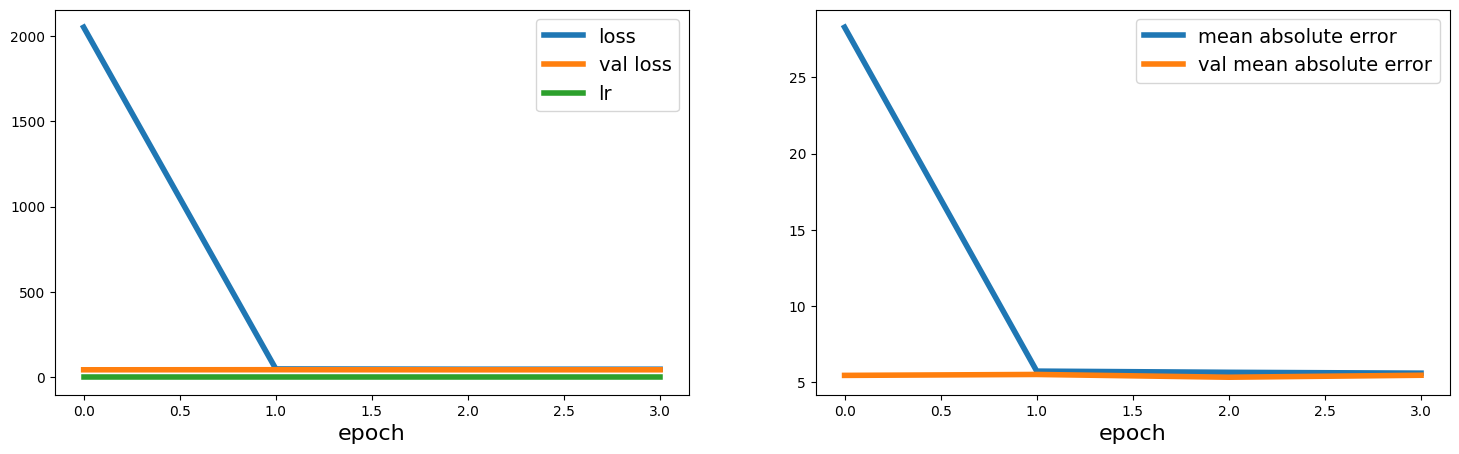

In [7]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(ann_history)


In [8]:
evaluation = ann.evaluate(x_test[:-1], y_test[:-1])

16/16 [==============================] - 19s 1s/step - loss: 50.5959 - mean_absolute_error: 5.7931


In [ ]:
fig = plt.figure()
plt.plot(ann_history.history['loss'], lw=4, label='loss')
plt.plot(ann_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(ann_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/history-"+tag+".png")

In [9]:
ann.save("archive/model-"+tag+".h5")
config = ann.get_config()
np.save("archive/config-"+tag+".npy", config)